In [1]:
!nvidia-smi

Fri Oct  4 07:15:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
!pip install efficientnet==1.1.1 # This is a shell command to install the efficientnet package. The '!' prefix indicates that it should be run as a shell command.

  Attempting uninstall: efficientnet
    Found existing installation: efficientnet 1.0.0
    Uninstalling efficientnet-1.0.0:
      Successfully uninstalled efficientnet-1.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
segmentation-models 1.0.1 requires efficientnet==1.0.0, but you have efficientnet 1.1.1 which is incompatible.


In [1]:

# install the segmentation_models library
import tensorflow as tf
import os
import glob
import random
import cv2
import numpy as np
import sklearn

from tqdm import tqdm
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import normalize
from sklearn.utils import class_weight
import segmentation_models as sm

# Set the framework to 'tf.keras' explicitly
sm.set_framework('tf.keras')
# Check if the framework is set correctly
print(sm.framework())

Segmentation Models: using `keras` framework.
tf.keras


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
SIZE_X = 128
SIZE_Y = 128
n_classes = 6
BATCH_SIZE = 16
EPOCHS = 10
def load_images_and_masks(image_dir, mask_dir, img_size=(SIZE_X, SIZE_Y)):
    images = []
    masks = []

    for img_path in glob.glob(os.path.join(image_dir, "*.jpg")):
        img = cv2.imread(img_path, 1)
        images.append(img)

    for mask_path in glob.glob(os.path.join(mask_dir, "*.png")):
        mask = cv2.imread(mask_path, 0)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load dataset
image_dir = "/content/drive/MyDrive/trial/images_"
mask_dir = "/content/drive/MyDrive/trial/masks_"
images, masks = load_images_and_masks(image_dir, mask_dir)

In [7]:
masks.shape

(101, 2160, 3840)

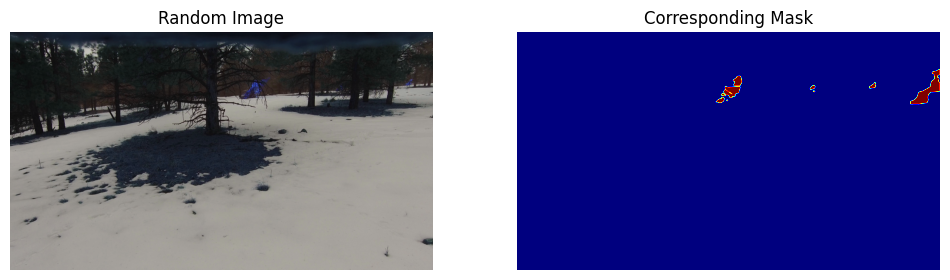

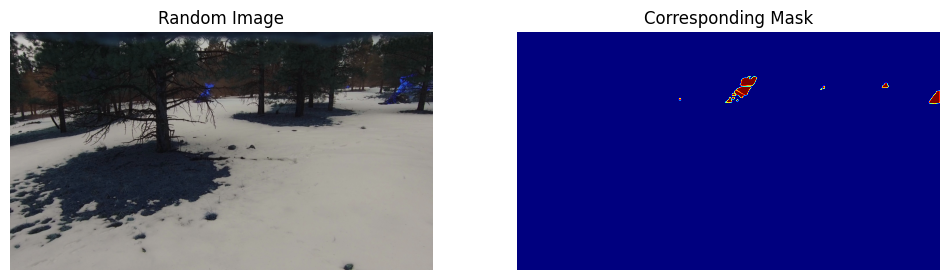

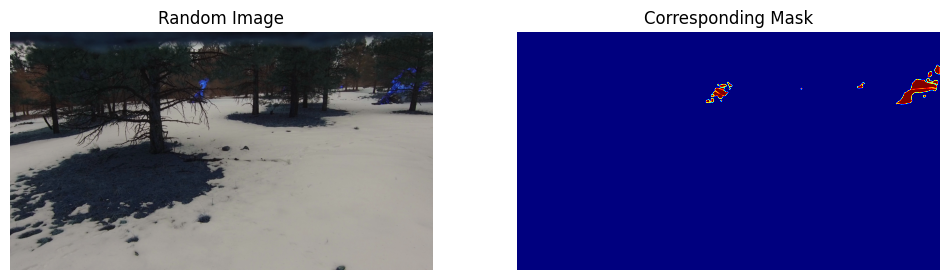

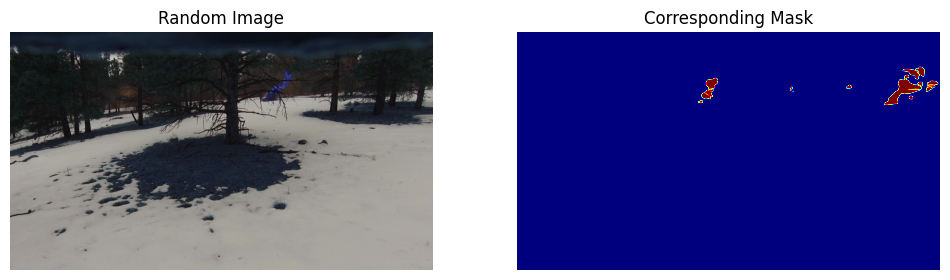

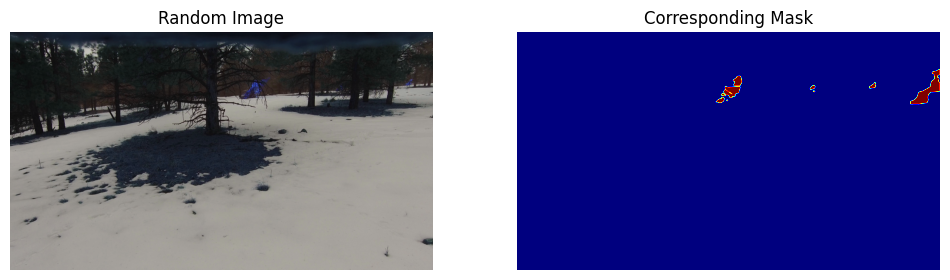

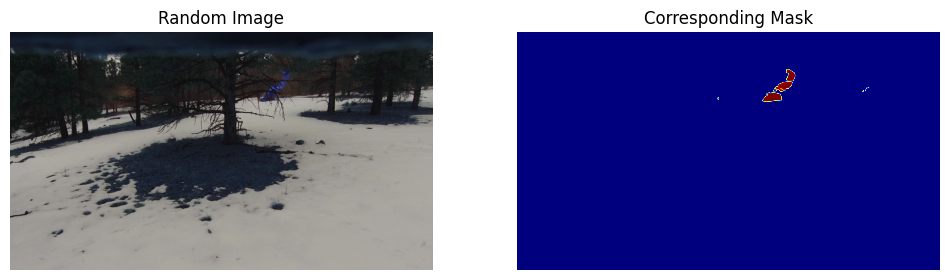

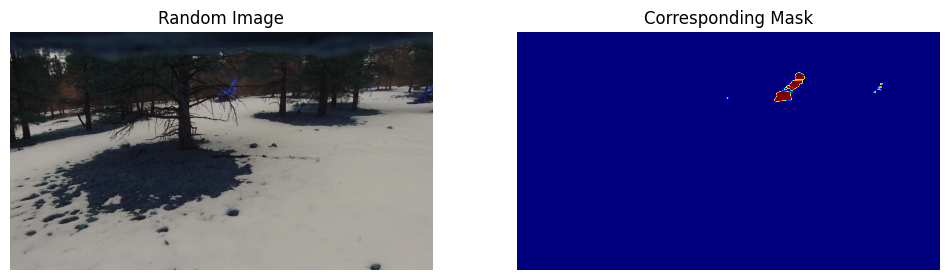

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot a random image and its corresponding mask
def plot_random_image_and_mask(images, masks):
    # Check if images and masks arrays are not empty
    if images.shape[0] == 0 or masks.shape[0] == 0:
        print("Images or masks arrays are empty.")
        return

    # Randomly select an index
    idx = np.random.randint(0, images.shape[0])

    # Get the selected image and mask
    image = images[idx]
    mask = masks[idx]

    # Plot the image and mask
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot image
    ax[0].imshow(image.squeeze(), cmap='gray')  # Adjust cmap based on image type
    ax[0].set_title('Random Image')
    ax[0].axis('off')

    # Plot mask
    ax[1].imshow(mask, cmap = 'jet')  # Use a colormap suitable for masks
    ax[1].set_title('Corresponding Mask')
    ax[1].axis('off')

    plt.show()

# Example usage with your dataset arrays
for i in range(0,7):
    plot_random_image_and_mask(images, masks)


In [9]:
np.unique(masks)

array([0, 1], dtype=uint8)

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize, to_categorical
labelencoder = LabelEncoder()
n, h, w = masks.shape
masks_reshaped = masks.reshape(-1, 1)
masks_reshaped_encoded = labelencoder.fit_transform(masks_reshaped)
masks_encoded_original_shape = masks_reshaped_encoded.reshape(n, h, w)

images = np.expand_dims(images, axis=4)
images = normalize(images, axis=1)


# Normalize images
#images = normalize(images, axis=1)

# Expand dimensions
#images = np.expand_dims(images, axis=3)
masks_input = np.expand_dims(masks_encoded_original_shape, axis=3)

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(images, masks_input, test_size=0.30, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=0)  # 0.33 * 0.30 = 0.10

n_classes = 7
# Convert masks to categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

NameError: name 'masks' is not defined

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(masks_reshaped_encoded),
                                                y= masks_reshaped_encoded)
class_weights = {i : class_weights[i] for i in range(7)}
print("Class weights are...:", class_weights)

NameError: name 'np' is not defined

In [ ]:
np.unique(masks_encoded_original_shape)

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [ ]:
model=sm.Unet('mobilenet',input_shape=(IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS), classes=7, activation='softmax')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 129, 129, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 32)   128         ['conv1[0][0]']              

 conv_pw_5_bn (BatchNormalizati  (None, 16, 16, 256)  1024       ['conv_pw_5[0][0]']              
 on)                                                                                              
                                                                                                  
 conv_pw_5_relu (ReLU)          (None, 16, 16, 256)  0           ['conv_pw_5_bn[0][0]']           
                                                                                                  
 conv_pad_6 (ZeroPadding2D)     (None, 17, 17, 256)  0           ['conv_pw_5_relu[0][0]']         
                                                                                                  
 conv_dw_6 (DepthwiseConv2D)    (None, 8, 8, 256)    2304        ['conv_pad_6[0][0]']             
                                                                                                  
 conv_dw_6_bn (BatchNormalizati  (None, 8, 8, 256)   1024        ['conv_dw_6[0][0]']              
 on)      

                                                                                                  
 conv_pw_11 (Conv2D)            (None, 8, 8, 512)    262144      ['conv_dw_11_relu[0][0]']        
                                                                                                  
 conv_pw_11_bn (BatchNormalizat  (None, 8, 8, 512)   2048        ['conv_pw_11[0][0]']             
 ion)                                                                                             
                                                                                                  
 conv_pw_11_relu (ReLU)         (None, 8, 8, 512)    0           ['conv_pw_11_bn[0][0]']          
                                                                                                  
 conv_pad_12 (ZeroPadding2D)    (None, 9, 9, 512)    0           ['conv_pw_11_relu[0][0]']        
                                                                                                  
 conv_dw_1

                                                                                                  
 decoder_stage2_upsampling (UpS  (None, 32, 32, 128)  0          ['decoder_stage1b_relu[0][0]']   
 ampling2D)                                                                                       
                                                                                                  
 decoder_stage2_concat (Concate  (None, 32, 32, 256)  0          ['decoder_stage2_upsampling[0][0]
 nate)                                                           ',                               
                                                                  'conv_pw_3_relu[0][0]']         
                                                                                                  
 decoder_stage2a_conv (Conv2D)  (None, 32, 32, 64)   147456      ['decoder_stage2_concat[0][0]']  
                                                                                                  
 decoder_s

In [ ]:
model.compile('Adam', loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train_cat,
                    batch_size = BATCH_SIZE,
                    verbose=1,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val_cat),# sample_weight=class_weights,
                    shuffle=True)

Epoch 1/50
243/243 [==============================] - 44s 99ms/step - loss: 0.7511 - accuracy: 0.7531 - val_loss: 1.5010 - val_accuracy: 0.6247
Epoch 2/50
243/243 [==============================] - 20s 83ms/step - loss: 0.5537 - accuracy: 0.8173 - val_loss: 0.9164 - val_accuracy: 0.6848
Epoch 3/50
243/243 [==============================] - 20s 84ms/step - loss: 0.4918 - accuracy: 0.8348 - val_loss: 0.6557 - val_accuracy: 0.7970
Epoch 4/50
243/243 [==============================] - 20s 83ms/step - loss: 0.4672 - accuracy: 0.8428 - val_loss: 0.5272 - val_accuracy: 0.8192
Epoch 5/50
243/243 [==============================] - 20s 84ms/step - loss: 0.4465 - accuracy: 0.8494 - val_loss: 0.5063 - val_accuracy: 0.8455
Epoch 6/50
243/243 [==============================] - 21s 84ms/step - loss: 0.4272 - accuracy: 0.8548 - val_loss: 0.4279 - val_accuracy: 0.8543
Epoch 7/50
243/243 [==============================] - 21s 85ms/step - loss: 0.4071 - accuracy: 0.8618 - val_loss: 0.4176 - val_accuracy:

In [ ]:
X_train.shape

(3874, 128, 128, 3, 1)

In [ ]:
model.save("mobb.h5")

In [ ]:
model.evaluate(X_test,y_test_cat)

35/35 [==============================] - 3s 63ms/step - loss: 0.6871 - accuracy: 0.8464


[0.6871227025985718, 0.8463907837867737]

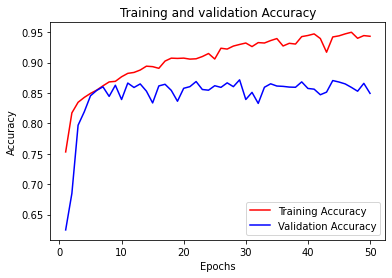

In [ ]:
acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)

val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

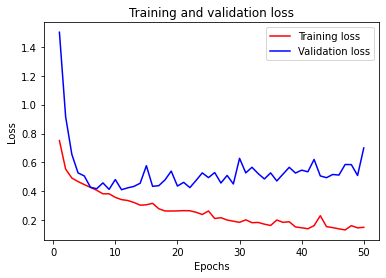

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 2s 2s/step


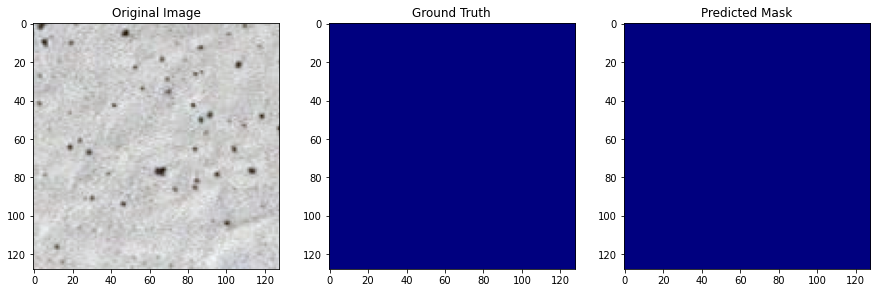

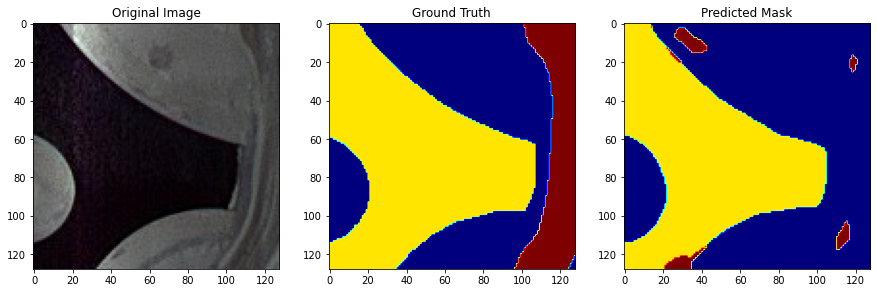

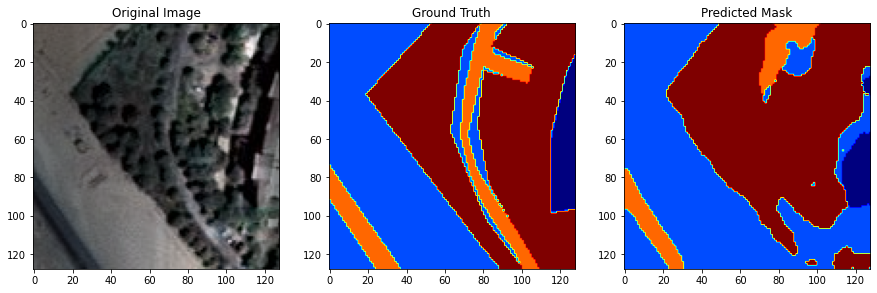

In [ ]:
num_images = 3
indices = np.random.choice(len(X_test), num_images, replace=False)
X_test_sample = X_test[indices]
y_test_sample = y_test[indices]
# Predict masks
y_pred_sample = model.predict(X_test_sample)
# Convert one-hot encoded predictions to class indices
y_pred_sample = np.argmax(y_pred_sample, axis=-1)
#y_test_sample = np.argmax(y_test_sample, axis=-1)
# Plot original images, ground truth, and predictions
for i in range(num_images):
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    min_val = np.min(X_test_sample[i])
    max_val = np.max(X_test_sample[i])
    original_image = (X_test_sample[i] - min_val) / (max_val - min_val) * 255
    #original_image = X_test_sample[i].squeeze() * 255.0
    #print(original_image.shape)
    #print(np.unique(original_image))
    plt.imshow(original_image[:,:,:,0].astype(np.uint8))
    plt.title('Original Image')

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_test_sample[i], cmap='jet')
    plt.title('Ground Truth')

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred_sample[i], cmap='jet')
    plt.title('Predicted Mask')

    plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import jaccard_score

# Function to calculate IoU
def calculate_iou(y_true, y_pred, num_classes):
    iou_list = []

    for cls in range(num_classes):
        true_class = (y_true == cls)
        pred_class = (y_pred == cls)

        intersection = np.logical_and(true_class, pred_class).sum()
        union = np.logical_or(true_class, pred_class).sum()

        if union == 0:
            iou = float('nan')  # To avoid division by zero
        else:
            iou = intersection / union
        iou_list.append(iou)

    return np.nanmean(iou_list)  # Ignore NaNs for classes not present in the batch

# Predict and calculate IoU
def predict_and_calculate_iou(model, X_test, y_test, num_classes):
    # Predict masks
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=-1)
    y_true = np.argmax(y_test, axis=-1)

    # Calculate IoU
    iou = calculate_iou(y_true, y_pred, num_classes)
    return iou

# Define number of classes
num_classes = 6

# Calculate IoU for the test set
iou = predict_and_calculate_iou(model, X_test, y_test_cat, num_classes)
print(f"Mean IoU: {iou}")


35/35 [==============================] - 1s 37ms/step


ResourceExhaustedError: OOM when allocating tensor with shape[1112,128,128,7] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat